NOTEBOOK IS A WORK IN PROGRESS

In [ ]:
%reload_ext autoreload 
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

In [ ]:
import jax
import jax.numpy as jnp
import hamux as hmx
import treex as tx
from flax import linen as nn # For initializers
import optax
import jax.tree_util as jtu
from typing import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from loguru import logger
from einops import rearrange
from tqdm.auto import trange, tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np
import functools as ft

import matplotlib.colors as colors
plt.set_cmap('bwr') # a good start: blue to white to red colormap

<Figure size 800x800 with 0 Axes>

In [ ]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [ ]:
def summarize_mnist_weights(ham, kh=32, kw=32, fig=None):
    # W2 = np.random.normal(size=(10,1024))
    norm = colors.TwoSlopeNorm(vcenter=0)

    Wimg = ham.synapses[0].W1
    Wlabel = ham.synapses[0].W2
    
    nWimg = jnp.sqrt(jnp.power(Wimg,2).sum(-2, keepdims=True))
    nWlabel = jnp.sqrt(jnp.power(Wlabel,2).sum(-2, keepdims=True))
    
    Wimg = Wimg / nWimg
    Wlabel = Wlabel / nWlabel
    
    # imgs_big = rearrange(np.repeat(imgs, 11, axis=0)[:1024], "... h w -> ... (h w)")[:,0].T
    Wimg_show = rearrange(Wimg, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw)
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=(2,5))
    else:
        axs = fig.subplots(1, 2, width_ratios=(2,5))
    def prep_axis(ax):
        ax.axis('off')
    [prep_axis(ax) for ax in axs]

    pos0 = axs[0].imshow(Wlabel.T[:20], aspect="auto", interpolation="nearest")
    # fig.colorbar(pos0, ax=axs[0], location="right", shrink=0.7)
    axs[0].set_title("Label matrix")

    pos1 = axs[1].imshow(Wimg_show, norm=norm)
    axs[1].set_title("pixel_matrix")
    fig.colorbar(pos1, ax=axs[1], location="right", shrink=0.7)


#     axs[2].set_title("activations")
#     pos2 = axs[2].imshow(W2[:1].T, aspect="auto", interpolation="nearest")
#     fig.colorbar(pos2, ax=axs[2], location="right")
    return fig

<matplotlib.image.AxesImage>

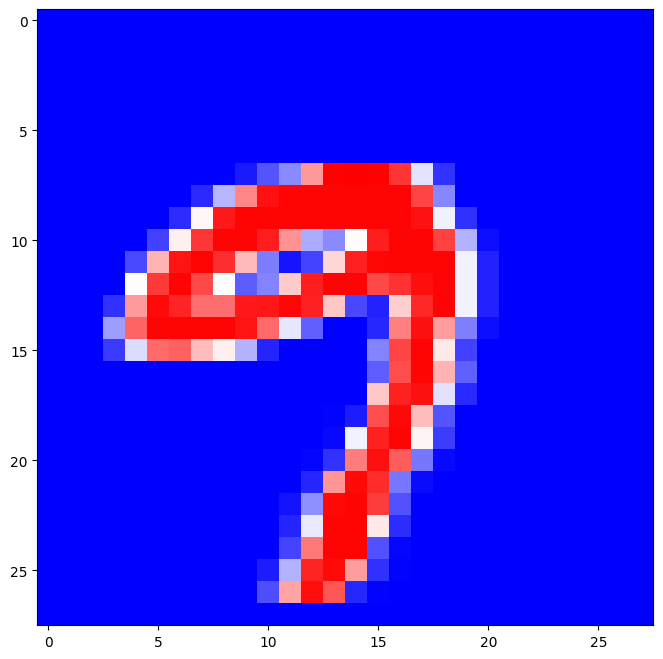

In [ ]:
from hamux.datasets import *

dl_args = DataloadingArgs(
    dataset="torch/MNIST",
    # aa="rand",
    aa=None,
    reprob=0.,
    vflip=0.0,
    hflip=0.0,
    scale=(0.9, 1.1),
    batch_size=100,
    color_jitter=0.0,
    validation_batch_size=1000,
)
data_config = DataConfigMNIST(input_size=(1, 28, 28), mean=0.5, std=0.5)

train_dl, eval_dl = create_dataloaders(dl_args, data_config)

for batch in train_dl:
    imgs, labels = batch
    break
    
plt.imshow(data_config.show(imgs[2]))

In [ ]:
def normal_init(std=1.0, mean=0.0):
    def _f(key, shape, dtype=jnp.float64):
        return (jax.random.normal(key, shape, dtype=dtype) * std) + mean
    return _f

class HopfieldNetworkAsSynapse(hmx.Synapse):
    """A simple reimplementation of a Hopfield Network as a synapse, returning the alignment"""
    W1: jnp.ndarray = tx.Parameter.node() # treex's preferred way of declaring an attribute as a parameter
    W2: jnp.ndarray = tx.Parameter.node()
    nhid: int
    beta: float = tx.Parameter.node()
    
    def __init__(self, nhid:int, beta_init=0.1):
        self.nhid = nhid
        self.beta = beta_init
    
    def __call__(self, g1, g2):
        """The alignment function, defined on an unbatched `g`"""
        if self.initializing():
            self.W1 = normal_init(mean=0.0, std=0.01)(tx.next_key(), g1.shape + (self.nhid,))
            self.W2 = normal_init(std=0.01)(tx.next_key(), g2.shape + (self.nhid,))
        # hidsig = g1 @ self.W1 + g2 @ self.W2
        # hidsig = - jnp.abs(self.W1 - g1[:,None]).sum(-2) - jnp.abs(self.W2 - g2[:,None]).sum(-2)
        # hidsig = - jnp.pow(jnp.abs(self.W1 - g1[:,None]),2).sum(-2) - jnp.pow(jnp.abs(self.W2 - g2[:,None]),2).sum(-2)

        # nW1 = jnp.abs(self.W1).sum(-2, keepdims=True)
        # nW2 = jnp.abs(self.W2).sum(-2, keepdims=True)
        nW1 = jnp.sqrt(jnp.power(self.W1,2).sum(-2, keepdims=True))
        nW2 = jnp.sqrt(jnp.power(self.W2,2).sum(-2, keepdims=True))
        
        hidsig = g1 @ (self.W1 / nW1) + g2 @ (self.W2 / nW2)

        # hid_lagrangian_value = 1/self.beta * jax.nn.logsumexp(self.beta * hidsig, axis=-1)
        hid_lagrangian_value = (1/self.beta * jnp.exp(self.beta * hidsig)).sum(-1)
        return hid_lagrangian_value
    
ImageLayer = hmx.Layer(hmx.lagrangians.LSphericalNorm(), (28*28,))
# ImageLayer = hmx.Layer(hmx.lagrangians.LTanh(beta=0.5), (28*28,))
LabelLayer = hmx.Layer(hmx.lagrangians.LSoftmax(beta=0.005), (10,))

layers = [ImageLayer, LabelLayer]
synapses = [HopfieldNetworkAsSynapse(nhid=32**2, beta_init=7.)]
connections = [((0,1),0)]
ham = hmx.HAM(layers, synapses, connections)

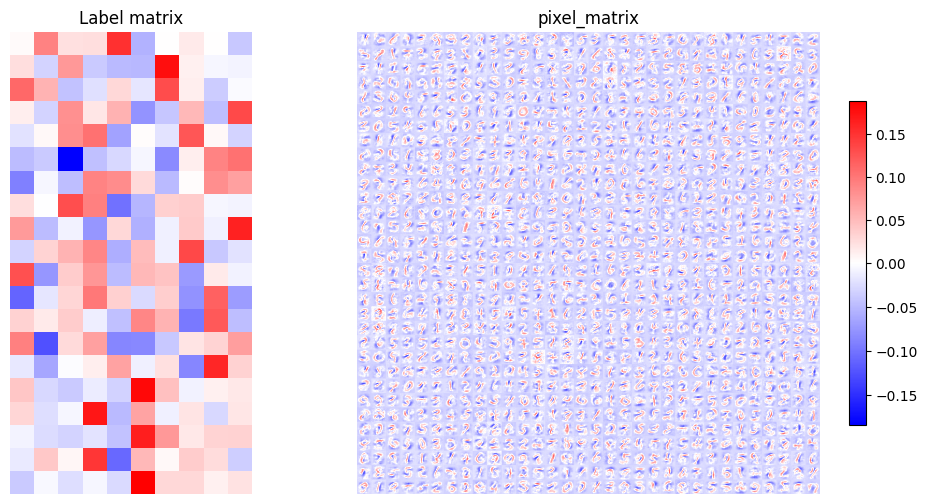

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(ham, model_fname)
summarize_mnist_weights(loaded_model);

In [ ]:
def fwd_energy(model, x, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    
    # if clamp_label is not None:
    #     xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1.)
    #     print(xs[-1])
    #     masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
img_start = batch[0][:1]
# img_start = jnp.ones_like(jnp.array(img_start))
energies, allxs = fwd_energy(loaded_model, img_start, dt=0.01, depth=60)

[<matplotlib.lines.Line2D>]

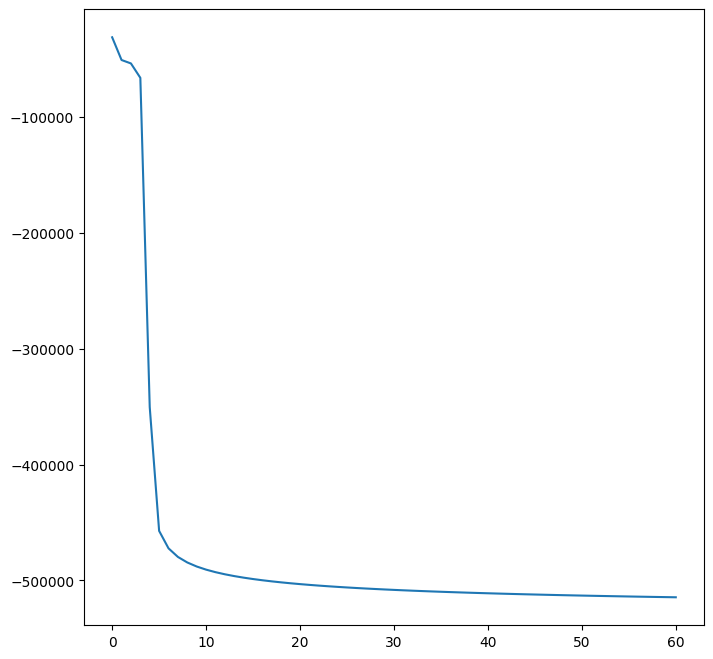

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

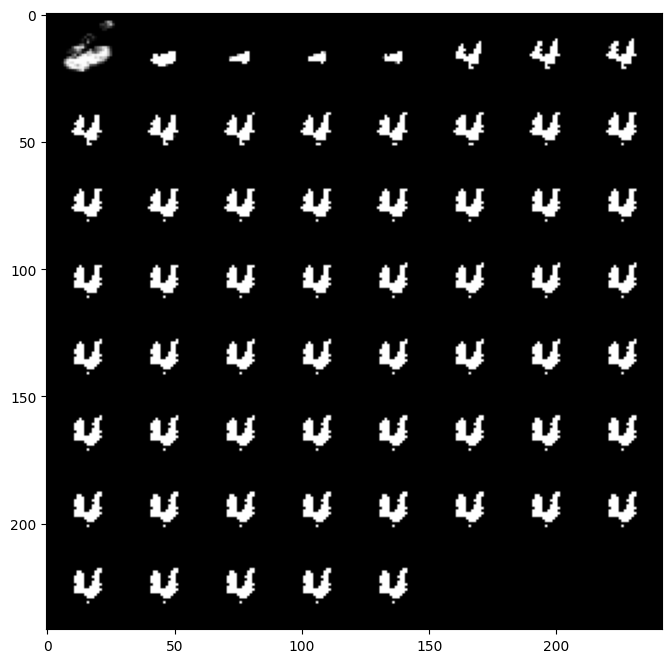

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

In [ ]:
# def fwd_energy(model, clamp_label:int, depth=4, dt=0.4, rng=None):
#     """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
#     # Initialize hidden states to our image
#     xs = model.init_states(1, rng=rng)
#     # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
#     # Masks allow us to clamp our label data over time
#     masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

#     xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
#     # xs[-1] = xs[-1].at[...,1].set(1000.)
#     print(xs[-1])
#     masks[-1] = jnp.zeros_like(masks[-1])

#     # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
#     all_xs = [xs]
#     energies = [model.venergy(xs)]

#     for i in range(depth):
#         updates = model.vupdates(xs)  # Calculate the updates
#         xs = model.step(
#             xs, updates, dt=dt, masks=masks
#         )  # Add them to our current states
#         all_xs.append(xs)
#         energies.append(model.venergy(xs))

#     # All labels have a softmax activation function as the last layer, spitting out probabilities
#     return jnp.stack(energies), all_xs

In [ ]:
# from torchvision.utils import make_grid
# img_start = batch[0][:1]

# def show_x(x):
#     x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
#     return data_config.show(torch.tensor(np.array(x)))

# # aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

# quick_fwd = jax.jit(fwd_energy, static_argnames=("depth"))

# # plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
# for i in range(10):
#     print(f"Starting {i}")
#     energies, allxs = quick_fwd(loaded_model, clamp_label=i, dt=1e-6, depth=50)
#     aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])
#     plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
#     plt.show()

In [ ]:
linit = jnp.zeros((10,)).at[1].set(1000.).at[0].set(1000.)
loaded_model.layers[-1].g(linit)

Array([0.48687777, 0.48687777, 0.00328056, 0.00328056, 0.00328056,
       0.00328056, 0.00328056, 0.00328056, 0.00328056, 0.00328056],      dtype=float32)

[<matplotlib.lines.Line2D>]

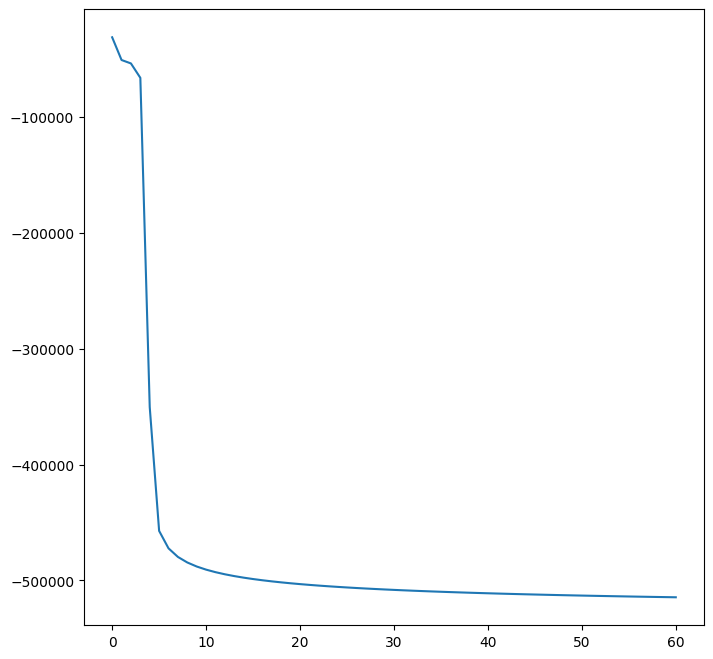

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

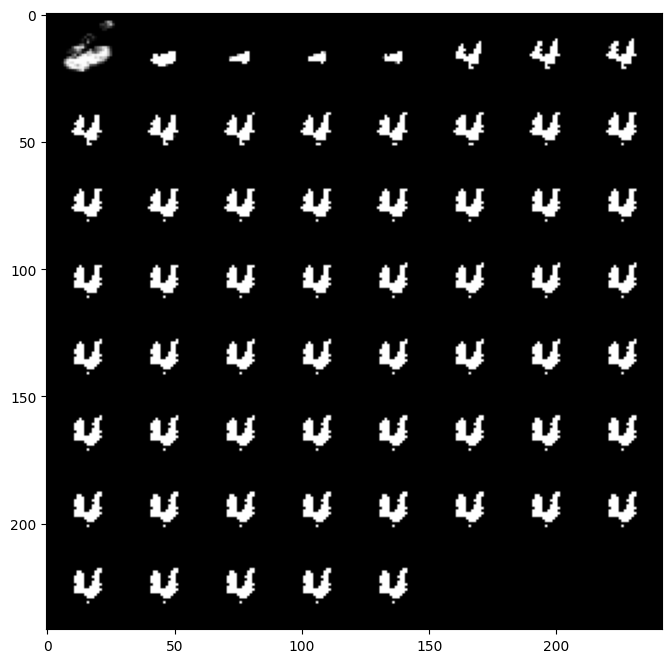

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

## TFJS

In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

2022-12-07 15:01:35.818824: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-07 15:01:36.689248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-07 15:01:36.689338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-07 15:01:36.689344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [ ]:
# # This is a helper function for running inference on a TensorFlow.js model
# # in Colab directly.

# _TFJS_SRC_URL = 'https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@3.11.0'

# # We have to make HTML resources persistent even if they are not explicitly passed
# # to JavaScript. Otherwise, they will get garbage collected.
# global_refs = {}

# def get_tfjs_predict_fn(model_dir):
#     """Load a TF SavedModel from `model_dir` and return a prediction function.

#     Caling the prediction function will run inference on the TFjs model in the
#     browser.

#     Arg:
#     model_dir: Location of the TF SavedModel.
#     """
#     model_path = os.path.join(model_dir, 'model.json')
#     ref = google.colab.html.create_resource(filepath=model_path, route=model_path)
#     weight_path = os.path.join(model_dir, 'group1-shard1of1.bin')

#     def add_resource(path):
#         with open(path, 'rb') as f:
#             return google.colab.html.create_resource(content=f.read(), route=path)

#     global global_refs
#     global_refs.update({
#       p: add_resource(p) for p in glob.glob(os.path.join(model_dir, '*.bin'))})

#     def call_tfjs(x):
#         """Calls the TFjs model in the browser and returns the output."""
#         print(f'NOTE: Running TFJs inference for model in {model_dir}...')
#         input_json = json.dumps(jax.tree_map(lambda x: x.tolist(), x))
#         display(HTML(f'<script src="{_TFJS_SRC_URL}"></script>'))
#         display(Javascript(string.Template('''
#           async function getOutput() {
#             const model = await tf.loadGraphModel('$model_url');
#             const x = tf.tensor(JSON.parse('$inputs'));
#             let result = model.predict(x);
#             console.log(result.shape);
#             return [await result.data(), result.shape];
#           }
#           window.modelOutput = getOutput();
#         ''').substitute(dict(model_url=ref.url, inputs=input_json))))

#         output_dict, shape = google.colab.output.eval_js('modelOutput')
#         return np.array([*output_dict.values()]).reshape(shape).astype(np.float32)
#     return call_tfjs

# def prod(params, xs):
#     return params['weight'] * xs

# params = {'weight': jnp.array([0.5, 1])}
# xs = np.arange(6).reshape((3, 2))
# jax_result = prod(params, xs)
# print(jax_result)

# model_dir = 'tfjs'
# tfjs.converters.convert_jax(
#     prod,
#     params,
#     input_signatures=[tf.TensorSpec((3, 2), tf.float32)],
#     model_dir=model_dir)

# # Verify the outputs have been written.
# !ls -l $model_dir

In [ ]:
# tfjs.converters.convert_jax(
#     prod,
#     params,
#     input_signatures=[tf.TensorSpec((3, 2), tf.float32)],
#     model_dir=model_dir)
# tfjs_predict_fn = get_tfjs_predict_fn(model_dir)
# print(tfjs_predict_fn(xs))  # Same output as JAX.


## HAMUX to TFJS

tfjs converters work by default assuming a `flax`-like API:

```
fn(params, ...) -> output
```

However, treex does not assume a `params` input. How can we port the converter to use treex?

The MNIST TFJS example uses the following flax code:

```
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x
```

In [ ]:
# 'Conv_0', 'Conv_1', 'Dense_0', 'Dense_1'

In [ ]:
# class CNN(tx.Module):
#     """A Simple CNN model"""
#     conv1: tx.Conv
#     conv2: tx.Conv
#     dense1: tx.Linear
#     dense2: tx.Linear
    
#     def __init__(self):
#         self.conv1 = tx.Conv(32, (3,3))
#         self.conv2 = tx.Conv(64, (2,2), strides=(2,2))
#         self.dense1 = tx.Linear(256)
#         self.dense2 = tx.Linear(10)
        
#     def __call__(self, x):
#         x = nn.relu(self.conv1(x))
#         x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
#         x = nn.relu(self.conv2(x))
#         x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
#         x = x.reshape((x.shape[0], -1))
#         x = nn.relu(self.dense1(x))
#         x = self.dense2(x)
#         return x

In [ ]:
# model = CNN().init(jax.random.PRNGKey(0), jnp.zeros((28,28,1)))

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(ham, model_fname)
# summarize_mnist_weights(loaded_model);

In [ ]:
# from jax.experimental.jax2tf.examples import jax2tfjs
import tensorflowjs as tfjs
import tensorflow as tf
import tempfile
from tensorflowjs.converters import tf_saved_model_conversion_v2 as saved_model_conversion
from jax.experimental import jax2tf

DType = Any
PolyShape = jax2tf.shape_poly.PolyShape
Array = Any
_TF_SERVING_KEY = tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY

In [ ]:

def fwd_energy_1step(model, img_pixels, labels, dt=0.4):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states()
    xs[0] = img_pixels
    xs[1] = labels
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    # xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    # print(xs[-1])
    masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images

    updates = model.updates(xs)  # Calculate the updates
    xs = model.step(
        xs, updates, dt=dt, masks=masks
    )  # Add them to our current states
    energy = jnp.array([model.energy(xs)])

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return energy, xs[0], xs[1]


class _ReusableSavedModelWrapper(tf.train.Checkpoint):
    """Wraps a function and its parameters for saving to a SavedModel.
    Implements the interface described at
    https://www.tensorflow.org/hub/reusable_saved_models.
    """

    def __init__(self, tf_graph, param_vars):
        """Args:
          tf_graph: a tf.function taking one argument (the inputs), which can be
             be tuples/lists/dictionaries of np.ndarray or tensors. The function
             may have references to the tf.Variables in `param_vars`.
          param_vars: the parameters, as tuples/lists/dictionaries of tf.Variable,
             to be saved as the variables of the SavedModel.
        """
        super().__init__()
        # Implement the interface from https://www.tensorflow.org/hub/reusable_saved_models
        self.variables = tf.nest.flatten(param_vars)
        self.trainable_variables = [v for v in self.variables if v.trainable]
        # If you intend to prescribe regularization terms for users of the model,
        # add them as @tf.functions with no inputs to this list. Else drop this.
        self.regularization_losses = []
        self.__call__ = tf_graph

def convert_jax(
    apply_fn: Callable[..., Any],
    # params: Array,
    *,
    input_signatures: Sequence[Tuple[Sequence[Union[int, None]], DType]],
    model_dir: str,
    polymorphic_shapes: Optional[Sequence[Union[str, PolyShape]]] = None):
    """Converts a JAX function `jax_apply_fn` and model parameters to a TensorflowJS model.

    Example usage for a Flax Module:

    ```
    import numpy as np
    from flax import linen as nn
    from jax import random
    import jax.numpy as jnp
    from tensorflowjs.converters.jax_conversion import convert_jax

    module = nn.Dense(features=4)
    inputs = jnp.ones((3, 4))
    params = module.init(random.PRNKey(0), inputs)['params']

    convert_jax(
    apply_fn=module.apply,
    params=params,
    input_signatures=[((3, 4), np.float32)],
    model_dir=tfjs_model_dir)
    ```

    Note that when using dynamic shapes, an additional argument
    `polymorphic_shapes` should be provided specifying values for the dynamic
    ("polymorphic") dimensions). See here for more details:
    https://github.com/google/jax/tree/main/jax/experimental/jax2tf#shape-polymorphic-conversion

    This is an adaption of the original implementation in jax2tf here:
    https://github.com/google/jax/blob/main/jax/experimental/jax2tf/examples/saved_model_lib.py

    Arguments:
    apply_fn: A JAX function that has one or more arguments, of which the first
      argument are the model parameters. This function typically is the forward
      pass of the network (e.g., `Module.apply()` in Flax).
    params: A Pytree containing the parameters of the module. These will all be
      converted to TF.Variables.
    input_signatures: the input signatures for the second and remaining
      arguments to `apply_fn` (the input). A signature must be a
      `tensorflow.TensorSpec` instance, or a (nested) tuple/list/dictionary
      thereof with a structure matching the second argument of `apply_fn`.
    model_dir: Directory where the TensorflowJS model will be written to.
    polymorphic_shapes: If given then it will be used as the
      `polymorphic_shapes` argument for the second parameter of `apply_fn`. In
      this case, a single `input_signatures` is supported, and should have
      `None` in the polymorphic (dynamic) dimensions.
    """
    if polymorphic_shapes is not None:
        # If polymorphic shapes are provided, add a polymorphic spec for the
        # first argument to `apply_fn`, which are the parameters.
        # polymorphic_shapes = [None, *polymorphic_shapes]
        pass

    tf_fn = jax2tf.convert(
        apply_fn,
        # Gradients must be included as 'PreventGradient' is not supported.
        with_gradient=True,
        polymorphic_shapes=polymorphic_shapes,
        # Do not use TFXLA Ops because these aren't supported by TFjs, but use
        # workarounds instead. More information:
        # https://github.com/google/jax/tree/main/jax/experimental/jax2tf#tensorflow-xla-ops
        enable_xla=False)

    # Create tf.Variables for the parameters. If you want more useful variable
    # names, you can use `tree.map_structure_with_path` from the `dm-tree`
    # package.
    param_vars = []
    # param_vars = tf.nest.map_structure(
    #     lambda param: tf.Variable(param, trainable=False), params)
    # Do not use TF's jit compilation on the function.
    tf_graph = tf.function(
        lambda *xs: tf_fn(*xs), autograph=False, jit_compile=False)

    # This signature is needed for TensorFlow Serving use.
    signatures = {
        _TF_SERVING_KEY: tf_graph.get_concrete_function(*input_signatures)
    }

    # wrapper = _ReusableSavedModelWrapper(tf_graph, None)
    wrapper = _ReusableSavedModelWrapper(tf_graph, param_vars)
    # wrapper = tf_graph
    saved_model_options = tf.saved_model.SaveOptions(
        experimental_custom_gradients=True)

    with tempfile.TemporaryDirectory() as saved_model_dir:
        tf.saved_model.save(
            wrapper,
            saved_model_dir,
            signatures=signatures,
            options=saved_model_options)
        saved_model_conversion.convert_tf_saved_model(saved_model_dir, model_dir, skip_op_check=True)


In [ ]:
# saved_model_conversion.convert_tf_frozen_model(

In [ ]:
myfwd = ft.partial(fwd_energy_1step, loaded_model)
output = myfwd(jnp.ones((1,784)), jnp.zeros((1,10)).at[0].set(1000), 0.2)
tfjs_model_dir = f'hamux_frontend/hamux_model/'
convert_jax(
    myfwd,
    input_signatures=[tf.TensorSpec((784,), tf.float32), tf.TensorSpec((10,), tf.float32), tf.TensorSpec((1,), tf.float32)],
    model_dir=tfjs_model_dir,
)

2022-12-07 15:01:40.307520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-07 15:01:40.307578: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-07 15:01:44.607154: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU d

Writing weight file hamux_frontend/hamux_model/model.json...


`=======`

In [ ]:
# # from jax.experimental.jax2tf.examples import jax2tfjs
# import tensorflowjs as tfjs
# import tensorflow as tf



# def fwd_energy(model, img_pixels, labels, dt=0.4):
#     """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
#     # Initialize hidden states to our image
#     xs = model.init_states(1)
#     # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
#     # Masks allow us to clamp our label data over time
#     masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

#     xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
#     # xs[-1] = xs[-1].at[...,1].set(1000.)
#     print(xs[-1])
#     masks[-1] = jnp.zeros_like(masks[-1])

#     # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
#     all_xs = [xs]
#     energies = [model.venergy(xs)]

#     for i in range(depth):
#         updates = model.vupdates(xs)  # Calculate the updates
#         xs = model.step(
#             xs, updates, dt=dt, masks=masks
#         )  # Add them to our current states
#         all_xs.append(xs)
#         energies.append(model.venergy(xs))

#     # All labels have a softmax activation function as the last layer, spitting out probabilities
#     return jnp.stack(energies), all_xs

In [ ]:
# tfjs_model_dir = f'tfjs_model'
# tfjs.converters.convert_jax(
#     fwd_energy,
#     loaded_model,
#     input_signatures=[tf.TensorSpec((1, 28, 28, 1), tf.float32), tf.TensorSpec((1,10), tf.float32), tf.float32],
#     model_dir=tfjs_model_dir,
# )

`>>>>>>> dev`

# Implement in FLAX

In [ ]:
from flax.core import freeze, unfreeze

In [ ]:
x1 = jax.random.normal(jax.random.PRNGKey(3), (784,))
x2 = jax.random.normal(jax.random.PRNGKey(3), (10,))

In [ ]:
L1 = hmx.lagrangians.lagr_spherical_norm(x1)
g1 = x1 / (jnp.sqrt(jnp.power(x1, 2).sum(axis=-1)) + 1e-5)
Lg1 = jax.grad(lambda x: hmx.lagrangians.lagr_spherical_norm(x).sum(-1))(x1)
assert jnp.allclose(g1, Lg1)

beta_label = 0.005
L2 = hmx.lagrangians.lagr_softmax(x2, beta=beta_label)
g2 = jax.nn.softmax( beta_label * x2, axis=-1)
Lg2 = jax.grad(lambda x: hmx.lagrangians.lagr_softmax(x, beta=beta_label).sum(-1))(x2)
assert jnp.allclose(g2, Lg2)

In [ ]:
def spherical_norm(x, eps=1e-5):
    nx = jnp.sqrt(jnp.power(x, 2).sum(axis=-1, keepdims=True)) + eps
    return x / nx

class MnistModel(nn.Module):
    hid_features: int = 1024
    beta_label: float = 0.005
    beta_hid: float = 7.0
    
    def setup(self):
        self.W1 = self.param('W1', nn.initializers.normal(0.01), (784, self.hid_features))
        self.W2 = self.param("W2", nn.initializers.normal(0.01), (10, self.hid_features))
    
    def __call__(self, x1, x2):
        """Calculate the updates for the next timestep of x1 and x2"""
        g1 = x1 / (jnp.sqrt(jnp.power(x1, 2).sum(axis=-1, keepdims=True)) + 1e-5)
        g1 = spherical_norm(x1)
        g2 = jax.nn.softmax(self.beta_label * x2, axis=-1)
        
        nW1 = jnp.sqrt(jnp.power(self.W1,2).sum(-2, keepdims=True))
        nW2 = jnp.sqrt(jnp.power(self.W2,2).sum(-2, keepdims=True))
        W1 = (self.W1 / nW1)
        W2 = (self.W2 / nW2)
        hidsig = ( g1 @ W1 + g2 @ W2)
        A = jnp.exp(self.beta_hid * hidsig)
        
        dEdg1, dEdg2 = x1 - A @ W1.T, x2 - A @ W2.T
        
        L1 = hmx.lagrangians.lagr_spherical_norm(x1)
        
        # L2 = (1/self.beta_label * jnp.log(jnp.sum(jnp.exp(self.beta_label * x2), axis=-1, keepdims=True)))
        L2 = (1/self.beta_label * jax.nn.logsumexp(self.beta_label * x2, axis=-1, keepdims=True))
        # L2 = hmx.lagrangians.lagr_softmax(x2, beta=self.beta_label)
        
        E1 = (x1 * g1).sum(-1) - L1
        E2 = (x2 * g2).sum(-1) - L2
        E = E1 + E2 - hmx.lagrangians.lagr_exp(hidsig, beta=self.beta_hid).sum(-1)
        
        return E, dEdg1, dEdg2


In [ ]:
model = MnistModel()
params = model.init(jax.random.PRNGKey(0), jnp.zeros((784,)), jnp.zeros((10,)))
new_params = unfreeze(params)
new_params['params']['W1'] = loaded_model.synapses[0].W1
new_params['params']['W2'] = loaded_model.synapses[0].W2
params = freeze(new_params)

In [ ]:
x1 = jax.random.normal(jax.random.PRNGKey(3), (784,))
x2 = jax.random.normal(jax.random.PRNGKey(3), (10,))
# x1 = jnp.ones((784,))
# x2 = jnp.ones((10,))
E, dEdg1, dEdg2 = model.apply(params, x1, x2)
[adEdg1, adEdg2] = loaded_model.dEdg([x1, x2])

assert jnp.allclose(dEdg1, adEdg1, atol=1e-6)
assert jnp.allclose(dEdg2, adEdg2, atol=1e-6)
assert jnp.allclose(E, loaded_model.energy([x1,x2]))

In [ ]:
from einops import rearrange

# def step(params, info):
#     # img = info['img']
#     # label = info['label']
#     img = info[0]
#     label = info[1]
    
def step(params, img, label):
    # img = imglabel[..., 10:]
    # label = jnp.copy(imglabel)[..., :10]
    # label = jnp.zeros(10)
    # label = imglabel[..., :10]
    # label = jnp.ones(10)
    # img = jnp.zeros(784)
# def step(params, img):
#     label = jnp.zeros(10)

# def step(params, img, label, dt=0.001):
    dt = 0.001
    # x1 = rearrange(img, "... h w -> ... (h w)")
    x1 = img
    x2 = label
    # return {
    #     "E": 5.,
    #     "x1": jnp.array([1,3.]),
    #     "x2": jnp.array([2,4,6,8.])
    # }
    E, dEdg1, dEdg2 = model.apply(params, x1, x2)
    # E, dEdg1, dEdg2 = model.apply(params, [x1, x2])

    
    x1next = x1 - dt * dEdg1
    x2next = x2 - dt * dEdg2
    # x1next = dEdg1
    # x2next = dEdg2
    
    # g1next = spherical_norm(x1next)
    # g2next = jax.nn.softmax(model.beta_label * x2next)
    return (E, x1next, x2next)
# {
#         "E": E,
#         "x1": x1next,
#         "x2": x2next
#     }
    # return E, x1next, x2next
    # return E

In [ ]:
# img = jax.random.normal(jax.random.PRNGKey(3), (28,28))
# img = jnp.array(imgs[0][0])
# img = jnp.zeros((28,28))
img = jnp.zeros((784,))
# img = jnp.zeros((794,))

x2 = jnp.zeros(10).at[4].set(1000).at[9].set(1040)

energies = []
all_imgs = []
x1 = spherical_norm(img)
# x1 = spherical_norm(rearrange(img, "... h w -> ... (h w)"))
# x1 = rearrange(x1, "... (h w) -> ... h w", h=28, w=28)
depth = 100
for i in range(depth):
    # E, x1next, x2next = step(params, x1, x2, 1e-6)
    # E = step(params, {"img": x1, "label":x2})
    # E = step(params, x1)
    
    # E, x1next, x2next = step(params, x1)
    # output = step(params, {"img": x1, "label":x2})
    # output = step(params, [x1, x2])
    # output = step(params, jnp.concatenate([x1, x2]))

    # output = step(params, x1)
    output = step(params, x1, x2)
    # E= output["E"]
    # x1 = output["x1"]
    # x2 = output["x2"]

    E, x1, x2 = output
    x1show = rearrange(x1, "... (h w) -> ... h w", h=28, w=28)
    energies.append(E)
    all_imgs.append(x1show)


<matplotlib.colorbar.Colorbar>

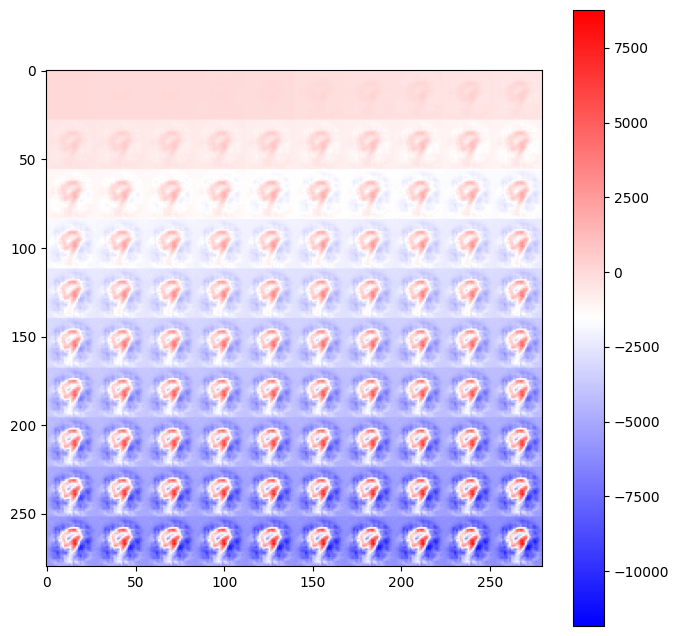

In [ ]:
# img_show = spherical_norm(rearrange(jnp.stack(all_imgs), "n h w -> n (h w)"))
# img_show = rearrange(img_show, "n (h w) -> n h w", h=28,w=28)

img_show = jnp.stack(all_imgs)
img_show = rearrange(img_show, "(kh kw) h w -> (kh h) (kw w)", kh=10, kw=10)
plt.imshow(img_show)
plt.colorbar()

[<matplotlib.lines.Line2D>]

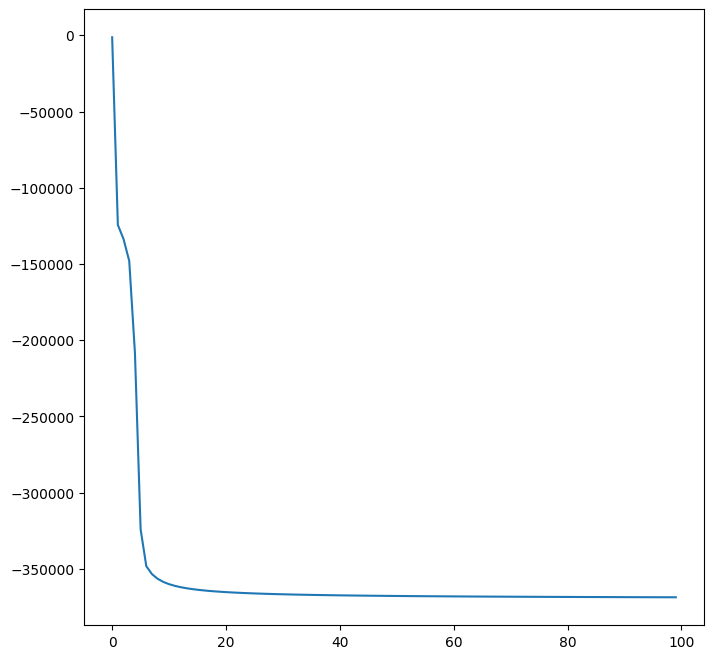

In [ ]:
plt.plot(jnp.stack(energies))

In [ ]:
def flax_convert_jax(
    apply_fn: Callable[..., Any],
    params: Array,
    *,
    input_signatures: Sequence[Tuple[Sequence[Union[int, None]], DType]],
    model_dir: str,
    polymorphic_shapes: Optional[Sequence[Union[str, PolyShape]]] = None):
    """Converts a JAX function `jax_apply_fn` and model parameters to a TensorflowJS model.

    Example usage for a Flax Module:

    ```
    import numpy as np
    from flax import linen as nn
    from jax import random
    import jax.numpy as jnp
    from tensorflowjs.converters.jax_conversion import convert_jax

    module = nn.Dense(features=4)
    inputs = jnp.ones((3, 4))
    params = module.init(random.PRNKey(0), inputs)['params']

    convert_jax(
    apply_fn=module.apply,
    params=params,
    input_signatures=[((3, 4), np.float32)],
    model_dir=tfjs_model_dir)
    ```

    Note that when using dynamic shapes, an additional argument
    `polymorphic_shapes` should be provided specifying values for the dynamic
    ("polymorphic") dimensions). See here for more details:
    https://github.com/google/jax/tree/main/jax/experimental/jax2tf#shape-polymorphic-conversion

    This is an adaption of the original implementation in jax2tf here:
    https://github.com/google/jax/blob/main/jax/experimental/jax2tf/examples/saved_model_lib.py

    Arguments:
    apply_fn: A JAX function that has one or more arguments, of which the first
      argument are the model parameters. This function typically is the forward
      pass of the network (e.g., `Module.apply()` in Flax).
    params: A Pytree containing the parameters of the module. These will all be
      converted to TF.Variables.
    input_signatures: the input signatures for the second and remaining
      arguments to `apply_fn` (the input). A signature must be a
      `tensorflow.TensorSpec` instance, or a (nested) tuple/list/dictionary
      thereof with a structure matching the second argument of `apply_fn`.
    model_dir: Directory where the TensorflowJS model will be written to.
    polymorphic_shapes: If given then it will be used as the
      `polymorphic_shapes` argument for the second parameter of `apply_fn`. In
      this case, a single `input_signatures` is supported, and should have
      `None` in the polymorphic (dynamic) dimensions.
    """
    if polymorphic_shapes is not None:
        # If polymorphic shapes are provided, add a polymorphic spec for the
        # first argument to `apply_fn`, which are the parameters.
        polymorphic_shapes = [None, *polymorphic_shapes]

    tf_fn = jax2tf.convert(
      apply_fn,
      # Gradients must be included as 'PreventGradient' is not supported.
      with_gradient=True,
      polymorphic_shapes=polymorphic_shapes,
      # Do not use TFXLA Ops because these aren't supported by TFjs, but use
      # workarounds instead. More information:
      # https://github.com/google/jax/tree/main/jax/experimental/jax2tf#tensorflow-xla-ops
      enable_xla=False)

    # Create tf.Variables for the parameters. If you want more useful variable
    # names, you can use `tree.map_structure_with_path` from the `dm-tree`
    # package.
    param_vars = tf.nest.map_structure(
      lambda param: tf.Variable(param, trainable=True), params)
    # Do not use TF's jit compilation on the function.
    tf_graph = tf.function(
      lambda *xs: tf_fn(param_vars, *xs), autograph=False, jit_compile=False, input_signature=input_signatures)
    # tf_graph = tf.function(
    #   lambda *xs: tf_fn(param_vars, *xs), autograph=False, jit_compile=False, )

    # This signature is needed for TensorFlow Serving use.
    signatures = {
      _TF_SERVING_KEY: tf_graph.get_concrete_function(*input_signatures)
    }

    wrapper = _ReusableSavedModelWrapper(tf_graph, param_vars)
    saved_model_options = tf.saved_model.SaveOptions(
      experimental_custom_gradients=True)

    with tempfile.TemporaryDirectory() as saved_model_dir:
        tf.saved_model.save(
            wrapper,
            saved_model_dir,
            signatures=signatures,
            options=saved_model_options)
        saved_model_conversion.convert_tf_saved_model(saved_model_dir, model_dir, strip_debug_ops=False, skip_op_check=True)

In [ ]:
tfjs_model_dir = f'flax_hamux_frontend/flax_model'
# tfjs.converters.convert_jax(
#     step,
#     params,
#     input_signatures=[tf.TensorSpec((1, 28, 28), tf.float32), tf.TensorSpec((1,10), tf.float32), tf.TensorSpec((1,), tf.float32)],
#     model_dir=tfjs_model_dir,
# )
flax_convert_jax(
    step,
    params,
    # input_signatures=({"img": tf.TensorSpec((1, 28, 28), tf.float32), "label": tf.TensorSpec((1,10), tf.float32)},),
    # input_signatures=[(tf.TensorSpec((1, 784), tf.float32), tf.TensorSpec((1,10), tf.float32),)],
    # input_signatures=[tf.TensorSpec((1, 28, 28), tf.float32), tf.TensorSpec((1,10), tf.float32), tf.TensorSpec((1,), tf.float32)],
    # input_signatures=[tf.TensorSpec((1, 28, 28), tf.float32)],
    # input_signatures=[tf.TensorSpec((1, 794), tf.float32)],
    # input_signatures=[tf.TensorSpec((1, 784), tf.float32)],
    input_signatures=[tf.TensorSpec((784,), tf.float32), tf.TensorSpec((10,), tf.float32)],
    model_dir=tfjs_model_dir,
)

2022-12-07 15:54:39.936570: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Writing weight file flax_hamux_frontend/flax_model/model.json...


# Can I successfully export their model?

In [ ]:
# !pip install -q flax ml_collections
# !pip install -q --upgrade git+https://github.com/google/jax tensorflowjs

In [ ]:
import tensorflowjs as tfjs

In [ ]:
if not os.path.isdir('flaxrepo'):
  !git clone --depth=1 https://github.com/google/flax flaxrepo
os.chdir('flaxrepo/examples/mnist')

# from google.colab import files
# files.view('train.py')

# Import `train.py`.
%load_ext autoreload
%autoreload 2
import train
# Import from `configs/default.py`
# and instantiate the default hyperparameter configuration.
from configs import default as config_lib
config = config_lib.get_config()
# config.num_epochs = 1  # fast training, e.g. for CPU
config

Cloning into 'flaxrepo'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 378 (delta 57), reused 156 (delta 36), pack-reused 0
Receiving objects: 100% (378/378), 2.27 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (57/57), done.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


batch_size: 128
learning_rate: 0.1
momentum: 0.9
num_epochs: 10

In [ ]:
# Load the dataset, split into the training and test sets, and train the model.
train_ds, test_ds = train.get_datasets()
state = train.train_and_evaluate(config, workdir=f'./workdir')

2022-12-07 08:00:44.300411: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/bhoover30/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


shape=(5, 28, 28, 1); value range [0.0..1.0]


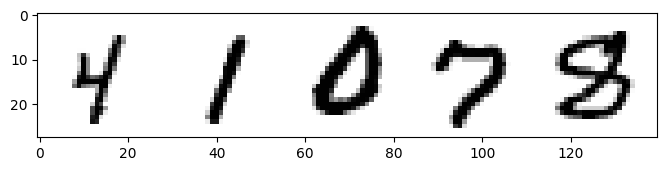

In [ ]:
# Sanity check: Load some images ...
imgs = np.array(train_ds['image'][:5])
plt.imshow(np.hstack(imgs)[..., 0], cmap='gray_r')
print(f'shape={imgs.shape}; value range [{imgs.min():.2}..{imgs.max():.2}]')

In [ ]:
# ... and confirm that model produces matching predictions.
logits = state.apply_fn({'params': state.params}, imgs)
logits.argmax(axis=1)

DeviceArray([4, 1, 0, 7, 8], dtype=int32)

In [ ]:
state.params.keys()

frozen_dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1'])

In [ ]:
# from jax.experimental.jax2tf.examples import jax2tfjs
import tensorflowjs as tfjs
import tensorflow as tf

In [ ]:
tfjs_model_dir = f'dummy_frontend/tfjs_model'
tfjs.converters.convert_jax(
    state.apply_fn,
    {'params': state.params},
    input_signatures=[tf.TensorSpec((1, 28, 28, 1), tf.float32)],
    model_dir=tfjs_model_dir,
)

Writing weight file dummy_frontend/tfjs_model/model.json...


2022-12-07 08:01:49.944891: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
